# Bitcoin Price Prediction
This notebook is inspired from the This Great book __Blueprints for Machine Learning and Data Science in Finance__ and its repo. 
### Applying CaseStudy3 - Chapter 6 but on BTC data from 2023 with 1 min INV



# This is a classification problem

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


<a id='Load The Data'></a>
## 1. Load The Data

In [2]:
drop=['high','low','open','close_time','quote_asset_volume','taker_buy_base_asset_volume',
        'number_of_trades','taker_buy_quote_asset_volume','ignore','timestamp']

In [3]:
df_original = pd.read_csv('BTC_1min_11_22_4.csv')
print(f'Data Shape--> {df_original.shape}')
df_original.head()

Data Shape--> (221680, 12)


,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2022-11-01 00:00:00,20490.74,20497.95,20471.34,20475.59,355.07194,1667260859999,7.273548e+06,5999,152.53099,3.124760e+06,0
1,2022-11-01 00:01:00,20474.28,20475.65,20460.98,20471.08,241.41379,1667260919999,4.941196e+06,5491,117.06667,2.396169e+06,0
2,2022-11-01 00:02:00,20471.08,20479.99,20464.42,20466.63,409.49444,1667260979999,8.383296e+06,7008,202.27747,4.141351e+06,0
3,2022-11-01 00:03:00,20467.36,20481.44,20457.14,20473.47,347.06217,1667261039999,7.103733e+06,7902,169.47176,3.468923e+06,0
4,2022-11-01 00:04:00,20473.47,20482.42,20467.12,20476.78,214.82770,1667261099999,4.398583e+06,5261,101.31632,2.074513e+06,0


<a id='Stats'></a>
## 2. Stats

In [4]:
df_original.describe()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
count,221680.000000,221680.000000,221680.000000,221680.000000,221680.000000,2.216800e+05,2.216800e+05,221680.000000,221680.000000,2.216800e+05,221680.0
mean,20725.102568,20733.830482,20716.459489,20725.136344,185.917634,1.673912e+12,3.896125e+06,4529.183711,92.616592,1.942024e+06,0.0
std,3812.943629,3815.511096,3810.286750,3812.973773,206.791430,3.840144e+09,4.545304e+06,3628.004444,104.694655,2.306978e+06,0.0
min,15513.840000,15544.470000,15476.000000,15513.840000,0.000000,1.667261e+12,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0
25%,16857.140000,16862.000000,16852.737500,16857.100000,77.636952,1.670586e+12,1.483476e+06,2397.000000,37.752898,7.235176e+05,0.0
50%,20872.810000,20884.580000,20863.520000,20872.775000,129.203650,1.673911e+12,2.589938e+06,3623.000000,63.840935,1.278130e+06,0.0
75%,23307.282500,23316.467500,23298.542500,23307.527500,218.191433,1.677236e+12,4.575574e+06,5572.000000,109.243377,2.285159e+06,0.0
max,29159.600000,29184.680000,29116.740000,29159.600000,5877.775450,1.680566e+12,1.459557e+08,107315.000000,3537.452960,8.791313e+07,0.0


<a id='Data Cleaning'></a>
## 3. Data Cleaning

In [5]:
#Nan Values
df_original.isna().sum()

timestamp                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
dtype: int64

__No NullValues__

<a id='Feature Engineering'></a>
## 4 Feature Engineering

<font color='cyan'> __Note that This part is copied from the book repo since it's an indicators and domain knowledge.__</font>

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [6]:
# Initialize the `signals` DataFrame with the `signal` column

# Create short simple moving average over the short window
df_original['short_mavg'] = df_original['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df_original['long_mavg'] = df_original['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
df_original['signal'] = np.where(df_original['short_mavg'] > df_original['long_mavg'], 1.0, 0.0)


In [7]:


#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

df_original['EMA10'] = EMA(df_original, 10)
df_original['EMA30'] = EMA(df_original, 30)
df_original['EMA200'] = EMA(df_original, 200)
df_original.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

df_original['ROC10'] = ROC(df_original['close'], 10)
df_original['ROC30'] = ROC(df_original['close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

df_original['MOM10'] = MOM(df_original['close'], 10)
df_original['MOM30'] = MOM(df_original['close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

df_original['RSI10'] = RSI(df_original['close'], 10)
df_original['RSI30'] = RSI(df_original['close'], 30)
df_original['RSI200'] = RSI(df_original['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

df_original['%K10'] = STOK(df_original['close'], df_original['low'], df_original['high'], 10)
df_original['%D10'] = STOD(df_original['close'], df_original['low'], df_original['high'], 10)
df_original['%K30'] = STOK(df_original['close'], df_original['low'], df_original['high'], 30)
df_original['%D30'] = STOD(df_original['close'], df_original['low'], df_original['high'], 30)
df_original['%K200'] = STOK(df_original['close'], df_original['low'], df_original['high'], 200)
df_original['%D200'] = STOD(df_original['close'], df_original['low'], df_original['high'], 200)

In [8]:
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df_original['MA21'] = MA(df_original, 10)
df_original['MA63'] = MA(df_original, 30)
df_original['MA252'] = MA(df_original, 200)
df_original.tail()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
221675,2023-04-03 23:55:00,27774.26,27785.84,27770.56,27776.67,44.76366,1680566159999,1.243429e+06,724,22.20905,...,48.745077,25.244444,17.661538,19.198170,12.940301,72.075373,70.688707,27814.739,27836.498000,27738.62000
221676,2023-04-03 23:56:00,27776.67,27793.65,27776.67,27793.65,24.66886,1680566219999,6.854006e+05,404,21.31472,...,48.972837,36.854701,28.565242,32.182947,22.690924,74.198510,72.682638,27805.505,27833.001333,27738.70230
221677,2023-04-03 23:57:00,27793.65,27794.84,27784.94,27792.38,22.11301,1680566279999,6.145434e+05,507,10.35733,...,48.956484,43.661855,35.253667,33.396789,28.259302,74.039712,73.437865,27798.715,27829.704667,27738.77770
221678,2023-04-03 23:58:00,27792.39,27798.89,27782.58,27782.80,36.26225,1680566339999,1.007807e+06,631,19.47639,...,48.832864,38.589100,39.701885,27.724111,31.101283,72.841853,73.693358,27791.865,27826.072667,27738.69160
221679,2023-04-03 23:59:00,27782.80,27809.30,27782.79,27800.00,46.15129,1680566399999,1.283072e+06,636,22.68424,...,49.064943,60.528431,47.593129,41.151561,34.090820,74.992498,73.958021,27788.563,27823.482667,27738.67165


In [9]:
#excluding columns that are not needed for our prediction.
drop.append('short_mavg')
drop.append('long_mavg')

df_original.drop(columns=drop,inplace=True)
print(f'Data Shape--> {df_original.shape}')
df_original.tail()

Data Shape--> (221680, 22)


,close,volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
221675,27776.67,44.76366,0.0,27801.475216,27832.916793,27825.558175,-0.392025,-0.436869,-92.19,-155.39,...,48.745077,25.244444,17.661538,19.198170,12.940301,72.075373,70.688707,27814.739,27836.498000,27738.62000
221676,27793.65,24.66886,0.0,27800.052449,27830.383452,27825.240681,-0.239158,-0.350038,-92.34,-104.90,...,48.972837,36.854701,28.565242,32.182947,22.690924,74.198510,72.682638,27805.505,27833.001333,27738.70230
221677,27792.38,22.11301,0.0,27798.657458,27827.931616,27824.913709,-0.211552,-0.356306,-67.90,-98.90,...,48.956484,43.661855,35.253667,33.396789,28.259302,74.039712,73.437865,27798.715,27829.704667,27738.77770
221678,27782.80,36.26225,0.0,27795.774284,27825.019899,27824.494667,-0.180433,-0.340415,-68.50,-108.96,...,48.832864,38.589100,39.701885,27.724111,31.101283,72.841853,73.693358,27791.865,27826.072667,27738.69160
221679,27800.00,46.15129,0.0,27796.542596,27823.405712,27824.250939,-0.088519,-0.308970,-33.02,-77.70,...,49.064943,60.528431,47.593129,41.151561,34.090820,74.992498,73.958021,27788.563,27823.482667,27738.67165


In [10]:
df_original = df_original.dropna(axis=0)
print(f'Data Shape--> {df_original.shape}')
df_original.tail()

Data Shape--> (221414, 22)


,close,volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
221675,27776.67,44.76366,0.0,27801.475216,27832.916793,27825.558175,-0.392025,-0.436869,-92.19,-155.39,...,48.745077,25.244444,17.661538,19.198170,12.940301,72.075373,70.688707,27814.739,27836.498000,27738.62000
221676,27793.65,24.66886,0.0,27800.052449,27830.383452,27825.240681,-0.239158,-0.350038,-92.34,-104.90,...,48.972837,36.854701,28.565242,32.182947,22.690924,74.198510,72.682638,27805.505,27833.001333,27738.70230
221677,27792.38,22.11301,0.0,27798.657458,27827.931616,27824.913709,-0.211552,-0.356306,-67.90,-98.90,...,48.956484,43.661855,35.253667,33.396789,28.259302,74.039712,73.437865,27798.715,27829.704667,27738.77770
221678,27782.80,36.26225,0.0,27795.774284,27825.019899,27824.494667,-0.180433,-0.340415,-68.50,-108.96,...,48.832864,38.589100,39.701885,27.724111,31.101283,72.841853,73.693358,27791.865,27826.072667,27738.69160
221679,27800.00,46.15129,0.0,27796.542596,27823.405712,27824.250939,-0.088519,-0.308970,-33.02,-77.70,...,49.064943,60.528431,47.593129,41.151561,34.090820,74.992498,73.958021,27788.563,27823.482667,27738.67165


In [11]:
df_original.columns

Index(['close', 'volume', 'signal', 'EMA10', 'EMA30', 'EMA200', 'ROC10',
       'ROC30', 'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%D10',
       '%K30', '%D30', '%K200', '%D200', 'MA21', 'MA63', 'MA252'],
      dtype='object')

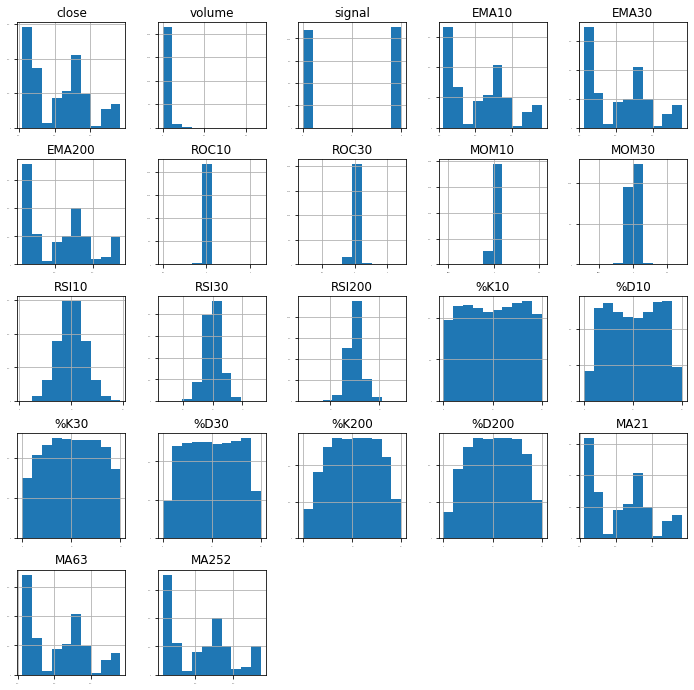

In [12]:
df_original.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

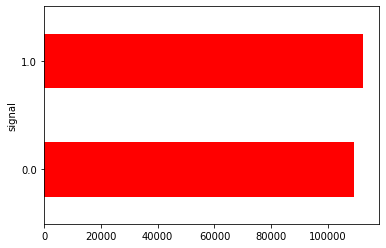

Baseline --> 0.5070727234953526


In [13]:
fig = plt.figure()
plot = df_original.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()
base_line=df_original['signal'].value_counts(normalize=True).max()
base_line=f'Baseline --> {base_line}'
print(base_line)

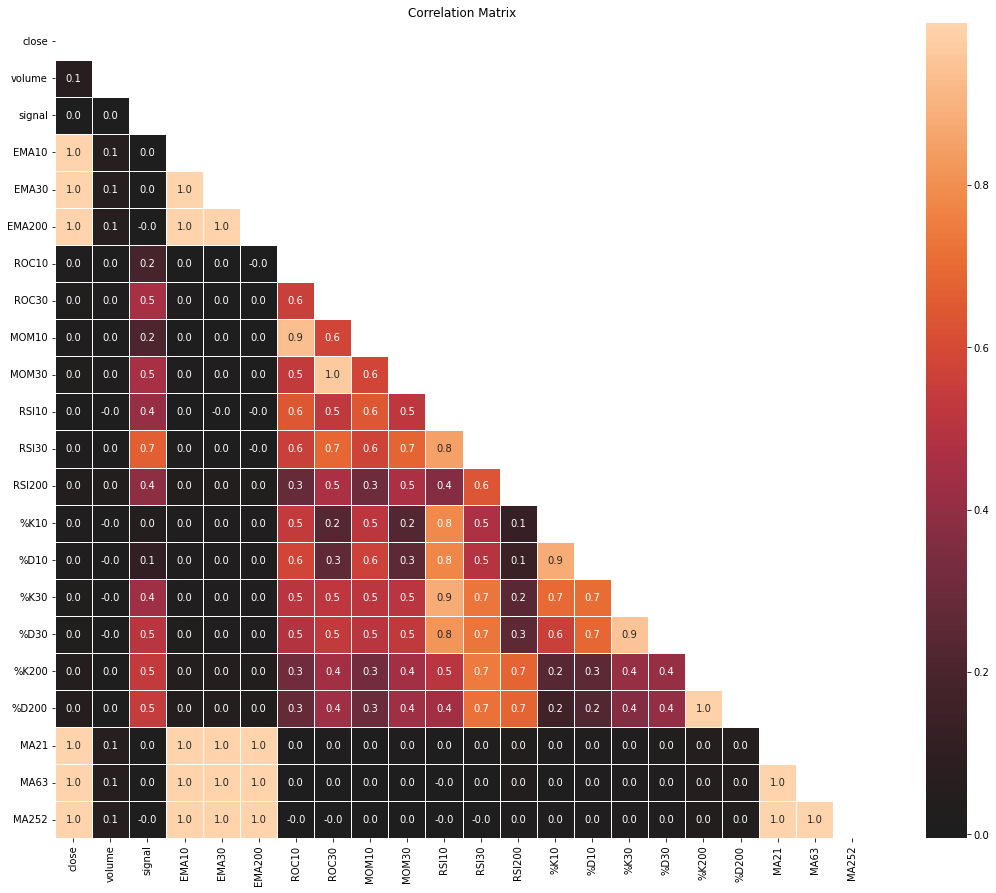

In [14]:
corr = df_original.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig ,ax= plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', center=0,square=True,linewidths=.5)
plt.title('Correlation Matrix');


#### best indicators based on the correlation with signal col __[ ROC30, MOM30, RSI30, %D30, %k200, %D200 ]__

# Split into Training Validation and Test

In [15]:
target='signal'
y=df_original[target]
X=df_original.drop(columns=target)
print(f'X--->{X.shape}')
print(f'y--->{y.shape}')

X--->(221414, 21)
y--->(221414,)


In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
print(f'X_train--->{X_train.shape}')
print(f'y_train--->{y_train.shape}')
print(f'X_test--->{X_test.shape}')
print(f'y_test--->{y_test.shape}')

X_train--->(177131, 21)
y_train--->(177131,)
X_test--->(44283, 21)
y_test--->(44283,)


In [17]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print(f'X_train--->{X_train.shape}')
print(f'y_train--->{y_train.shape}')
print(f'X_val--->{X_val.shape}')
print(f'y_val--->{y_val.shape}')

X_train--->(141704, 21)
y_train--->(141704,)
X_val--->(35427, 21)
y_val--->(35427,)


# Models

In [18]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
print(models)

[('LR', LogisticRegression(n_jobs=-1)), ('LDA', LinearDiscriminantAnalysis()), ('CART', DecisionTreeClassifier()), ('RF', RandomForestClassifier(n_jobs=-1))]


In [19]:
results = []
names = []
for name, model in models:
    kfold = 5
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    result = f"{name}: {round(cv_results.mean(),3)} ({round(cv_results.std(),3)})"
    print(result)

LR: 0.858 (0.004)
LDA: 0.907 (0.001)
CART: 0.889 (0.001)
RF: 0.925 (0.001)


__Random forest is selected for the grid search as it is the best model out of all.__

In [20]:
clf=RandomForestClassifier(random_state=42)
print(clf)

RandomForestClassifier(random_state=42)


In [21]:
cv_acc_score=cross_val_score(clf,X_train,y_train,cv=5,n_jobs=-1)
print(cv_acc_score)

[0.92329134 0.92350305 0.92290321 0.92540842 0.92568807]


In [22]:
params={
    'n_estimators':range(25,100,25),
    'max_depth':range(10,50,10),
}
params

{'n_estimators': range(25, 100, 25), 'max_depth': range(10, 50, 10)}

In [23]:
model=GridSearchCV(clf,
                param_grid=params,
                cv=5,
                n_jobs=-1,
                verbose=1
)

model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [24]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

## I think i Damaged my 5th gen CPU ........ XD

In [26]:
cv_result=pd.DataFrame(model.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.745197,0.457814,0.131402,0.012109,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.910518,0.909425,0.911859,0.910624,0.911609,0.910807,0.000869,12
1,41.091794,0.756495,0.274402,0.013186,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.911259,0.910130,0.910448,0.910518,0.911997,0.910871,0.000674,11
2,64.459998,1.041490,0.403802,0.014076,10,75,"{'max_depth': 10, 'n_estimators': 75}",0.910554,0.911577,0.911647,0.911259,0.912068,0.911421,0.000504,10
3,29.659996,0.204899,0.215599,0.009912,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.920539,0.921104,0.920080,0.920680,0.922759,0.921033,0.000923,9
4,59.996397,0.657257,0.443201,0.030109,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.921386,0.923644,0.922656,0.923291,0.924594,0.923114,0.001068,6


In [27]:
model.best_score_

0.9239682837781841

In [30]:
acc_train=model.score(X_train,y_train)
acc_val=model.score(X_val,y_val)
acc_test=model.score(X_test,y_test)
print(f'Training Score {acc_train}')
print(f'Val Score {acc_val}')
print(f'test Score {acc_test}')

Training Score 0.999682436628465
Val Score 0.9250571597933779
test Score 0.9242147099338347


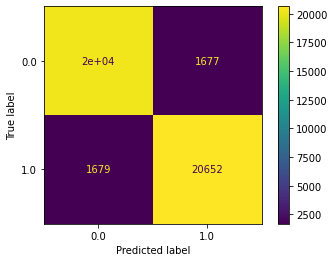

In [32]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

In [36]:

imp=model.best_estimator_.feature_importances_
imp

array([0.00859819, 0.01487747, 0.00874392, 0.00879826, 0.00893972,
       0.02799192, 0.12354425, 0.01944503, 0.15248353, 0.04024443,
       0.26255954, 0.02797704, 0.05828785, 0.03129315, 0.0364749 ,
       0.05001499, 0.04046079, 0.05293112, 0.00862251, 0.00869506,
       0.00901635])

In [37]:
features=X_train.columns

In [39]:
feat_imp=pd.Series(imp,index=features).sort_values()
feat_imp.tail()

%D200    0.052931
%K10     0.058288
ROC30    0.123544
MOM30    0.152484
RSI30    0.262560
dtype: float64

In [55]:
fig=px.bar(feat_imp.tail(15),orientation='h',title='Best 15 Indicators')
fig.update_layout(xaxis_title='Importance',yaxis_title='Indicators')

fig.show()

## Saving the model for later use

In [56]:
import pickle as pickle
with open("model_BTC_RF",'wb')as f :
    pickle.dump(model,f)